In [52]:
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET
from collections import defaultdict

import matplotlib.pyplot as plt

In [2]:
# generate list of file paths for xml metadata
xml_directory = 'data/xml/'
xml_files = os.listdir(xml_directory)
xml_files = [xml_directory+file for file in xml_files]

In [16]:
def get_metadata(xml_file_path):
    """Parses metadata from input xml file and returns as a Series"""
    tree = ET.parse(xml_file_path)# parse xml file
    article_meta = tree.getroot()[0][1] # get article metadata branch
    metadata = defaultdict(str) # create empty dict for metadata
    
    # file name
    txt_file_path = os.path.split(xml_file_path)[1]
    txt_file_path = os.path.splitext(txt_file_path)[0] + '.txt'
    metadata['filename'] = txt_file_path
    
    # get article IDs
    article_ids = article_meta.iter('article-id')
    for i in article_ids:
        metadata[i.attrib['pub-id-type']+'-id'] = i.text

    # get title
    for i in article_meta.iter('article-title'):
        metadata['title'] += i.text

    # get authors
    authors = []
    for contrib in article_meta.iter('contrib'):
        for string_name in contrib.findall('string-name'):
            surname = string_name.findtext('surname')
            given_names = string_name.findtext('given-names')
            name = f'{surname}, {given_names}'
            authors.append(name)
    metadata['authors'] = '; '.join(authors)

    # get year, month, volume, issue, page numbers
    metadata['year'] = article_meta.find('pub-date').find('year').text
    metadata['month'] = article_meta.find('pub-date').find('month').text
    metadata['volume'] = article_meta.find('volume').text
    try:
        metadata['issue'] = article_meta.find('issue').text
    except:
        metadata['issue'] = ''
    try:
        metadata['pages'] = str(article_meta.find('fpage').text) + "-" + str(article_meta.find('lpage').text)
    except:
        metadata['pages'] = ''

    # get keywords
    try:
        metadata['keywords'] = '; '.join([kwd.text for kwd in article_meta.find('kwd-group').findall('kwd')])
    except AttributeError:
        metadata['keywords'] = ''

    # get abstract
    abstract = article_meta.iter('abstract')
    for a in abstract:
        for i in a:
            metadata['abstract'] += i.text + " "

    return pd.Series(metadata)

In [56]:
df = pd.DataFrame([get_metadata(file) for file in xml_files])
df.head(5)

,filename,jstor-id,title,authors,year,month,volume,issue,pages,keywords,abstract,pub-doi-id
0,journal-article-10.2307_1353809.txt,1353809,Volume Information,,1999,12,266,1437,2553-xvii,,NaN,NaN
1,journal-article-10.2307_1353810.txt,1353810,Front Matter,,1999,12,266,1437,None-None,,NaN,NaN
2,journal-article-10.2307_1353811.txt,1353811,Knowing No Fear,"Sprengelmeyer, Reiner; Young, Andrew W.; Schro...",1999,12,266,1437,2451-2456,Amygdala; Facial expression; Emotion recogniti...,People with brain injuries involving the amygd...,NaN
3,journal-article-10.2307_1353812.txt,1353812,Anti-Predator Behaviour Changes Following an A...,"Díaz-Uriarte, Ramón",1999,12,266,1437,2457-2464,Anti-predator behaviour; Predation risk; Aggre...,Avoiding predators may conflict with territori...,NaN
4,journal-article-10.2307_1353813.txt,1353813,Regulation of Queen-Worker Conflict in Bumble-...,"Bloch, Guy",1999,12,266,1437,2465-2469,Social evolution; Bumble-bees; Reproduction; Q...,In annual colonies of bumble-bees overt queen-...,NaN


### explore metadata to check for errors

In [57]:
df.year = df.year.astype(int)

In [58]:
# check for duplicate jstor-ids:
df['jstor-id'].value_counts(dropna=False).value_counts()

1    16842
Name: jstor-id, dtype: int64

All rows have a unique, non-null jstor-id

In [59]:
# check for duplicate pub-doi-ids
df['pub-doi-id'].value_counts(dropna=False).value_counts()

1        2170
2          12
14648       1
Name: pub-doi-id, dtype: int64

In [60]:
# some doi-ids are duplicated - investigate
doi_notnulls = df[df['pub-doi-id'].notnull()]
doi_notnulls[doi_notnulls['pub-doi-id'].duplicated(keep=False)].sort_values('pub-doi-id')

,filename,jstor-id,title,authors,year,month,volume,issue,pages,keywords,abstract,pub-doi-id
3063,journal-article-10.2307_30047881.txt,30047881,Errata: Genetic Variation for an Aphid Wing Po...,"Braendle, Christian; Friebe, Ilvy; Caillaud, M...",2005,12,272,1581,2659-2659,,NaN,10.1098/rspb.2004.2995
3080,journal-article-10.2307_30047899.txt,30047899,Genetic Variation for an Aphid Wing Polyphenis...,"Braendle, Christian; Friebe, Ilvy; Caillaud, M...",2005,3,272,1563,657-664,Acyrthosiphon pisum; alternative phenotypes; a...,Many polyphenisms are examples of adaptive phe...,10.1098/rspb.2004.2995
2868,journal-article-10.2307_30047675.txt,30047675,Supply-Side Invasion Ecology: Characterizing P...,"Verling, Emma; Ruiz, Gregory M.; Smith, L. Dav...",2005,6,272,1569,1249-1256,biological invasion; ballast water; propagule ...,The observed rates and deleterious impacts of ...,10.1098/rspb.2005.3090
3064,journal-article-10.2307_30047882.txt,30047882,Errata: Supply-Side Invasion Ecology: Characte...,"Verling, Emma; Ruiz, Gregory M.; Smith, L. Dav...",2005,12,272,1581,2659-2659,,NaN,10.1098/rspb.2005.3090
3015,journal-article-10.2307_30047831.txt,30047831,Cattle Domestication in the Near East Was Foll...,"Götherström, Anders; Anderung, Cecilia; Hellbo...",2005,11,272,1579,2345-2350,cattle; wild ox; domestication; Y chromosome; ...,Domesticated cattle were one of the cornerston...,10.1098/rspb.2005.3243
3065,journal-article-10.2307_30047883.txt,30047883,Errata: Cattle Domestication in the near East ...,"Götherstöm, Anders; Anderung, Cecilia; Hellbor...",2005,12,272,1581,2660-2660,,NaN,10.1098/rspb.2005.3243
913,journal-article-10.2307_25223556.txt,25223556,Editorial,"Hill, Bill",2006,8,273,1597,1985-1985,,NaN,10.1098/rspb.2006.3652
943,journal-article-10.2307_25223587.txt,25223587,Crossing the Impassable: Genetic Connections i...,"Lessios, H. A.; Robertson, D. R.",2006,9,273,1598,2201-2208,dispersal; marine biogeography; Pacific Ocean;...,The 'impassable' Eastern Pacific Barrier (EPB)...,10.1098/rspb.2006.3652
1713,journal-article-10.2307_25249639.txt,25249639,The Early Evolution of Feathers: Fossil Eviden...,"Perrichot, Vincent; Marion, Loïc; Néraudeau, D...",2008,5,275,1639,1197-1202,Feather evolution; Early stages; Cretaceous am...,The developmental stages of feathers are of ma...,10.1098/rspb.2008.0003
3510,journal-article-10.2307_30245016.txt,30245016,Reversal of Evolutionary Downsizing Caused by ...,"Conover, David O.; Munch, Stephan B.; Arnott, ...",2009,6,276,1664,2015-2020,fisheries management; fishery-induced evolutio...,Evolutionary responses to the long-term exploi...,10.1098/rspb.2008.0003


In [61]:
# # save as .csv
# df.to_csv('data/metadata.csv.gz', index=False, sep='\t', compression='gzip')

## Metadata exploration

In [62]:
# are there missing (or empty-string) values?
(df == '').sum()

/home/omlean/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


filename          0
jstor-id          0
title             0
authors        1973
year              0
month             0
volume            0
issue           200
pages           802
keywords      11988
abstract          0
pub-doi-id        0
dtype: int64

In [63]:
df[df.authors == ''].title.value_counts()

Front Matter                                                                                                          690
Back Matter                                                                                                           686
Volume Information                                                                                                    345
Obituary Notices of Fellows Deceased                                                                                   25
Obituary Notices                                                                                                        4
                                                                                                                     ... 
Correction: Evolutional trends and palaeobiogeography of the Ordovician trilobite Ovalocephalus Koroleva, 1959          1
Correction: Intraspecific morphological and genetic variation of common species predicts ranges of threatened ones      1
Address of the President

In [64]:
df.isnull().sum()

filename          0
jstor-id          0
title             0
authors           0
year              0
month             0
volume            0
issue             0
pages             0
keywords          0
abstract       4795
pub-doi-id    14648
dtype: int64

([<matplotlib.axis.XTick at 0x7fc6b2a31f40>,
 <a list of 23 Text major ticklabel objects>)

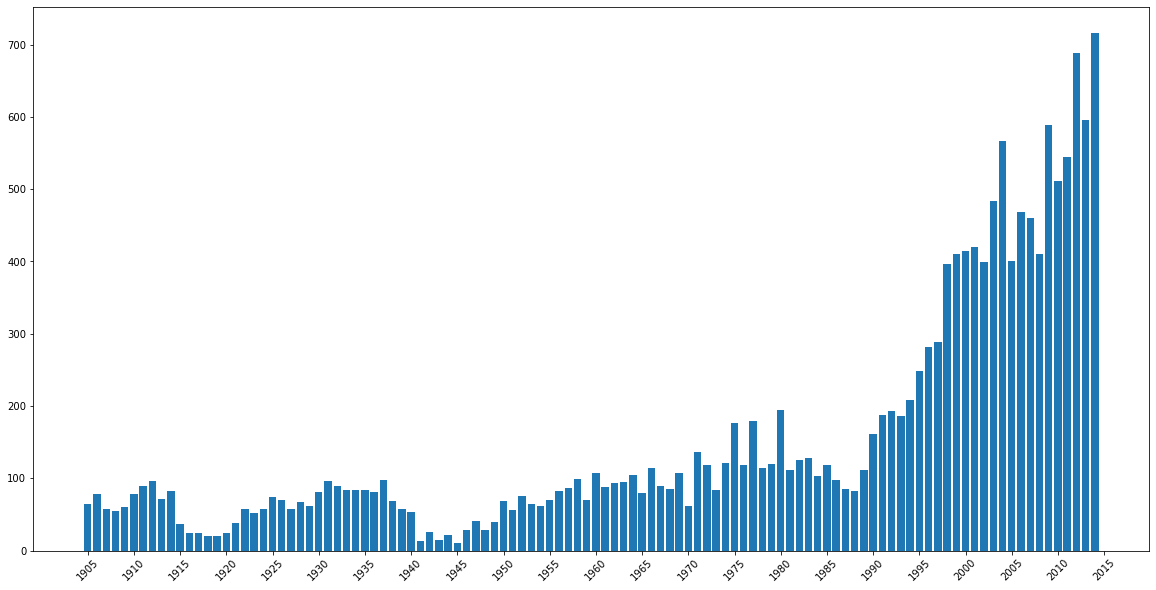

In [67]:
# What years were the paper published?
years = df.year.value_counts().sort_index()
plt.figure(figsize=(20,10))
plt.bar(years.index, years.values)
plt.xticks(np.arange(1905, 2016, 5), rotation=45)